# Домашнее задание № 2. Мешок слов

In [ ]:
!pip install razdel

In [ ]:
!pip install pymystem3

## Задание 1 (3 балла)

У векторайзеров в sklearn есть встроенная токенизация на регулярных выражениях. Найдите способо заменить её на кастомную токенизацию

Обучите векторайзер с дефолтной токенизацией, с токенизацией razdel.tokenize и с токенизацией+лемматизацией из mystem. Обучите классификатор (любой) с каждым из векторизаторов. Сравните метрики и выберите победителя.

(в вашей тетрадке должен быть код обучения и все метрики; если вы сдаете в .py файлах то сохраните полученные метрики в отдельном файле или в комментариях)

In [ ]:
import pandas as pd
from razdel import tokenize
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
data = pd.read_csv('labeled.csv')
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [ ]:
train, test = train_test_split(data, test_size=0.1, shuffle=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [ ]:
data.iloc[3].comment

'Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n'

In [ ]:
y_train = train.toxic
y_test = test.toxic

### Стандартный векторизатор

In [ ]:
count_vectorizer = CountVectorizer()
X_default = count_vectorizer.fit_transform(train.comment)
X_test_default = count_vectorizer.transform(test.comment)

### Razdel токенизация

In [ ]:
def razdel_tokenizer(text):
    return [t.text for t in tokenize(text)]

In [ ]:
razdel_vectorizer = CountVectorizer(tokenizer=razdel_tokenizer, token_pattern=None)
X_razdel = razdel_vectorizer.fit_transform(train.comment)
X_test_razdel = razdel_vectorizer.transform(test.comment)

In [ ]:
print(razdel_tokenizer(data.iloc[3].comment))

['Страницу', 'обнови', ',', 'дебил', '.', 'Это', 'тоже', 'не', 'оскорбление', ',', 'а', 'доказанный', 'факт', '-', 'не-дебил', 'про', 'себя', 'во', 'множественном', 'числе', 'писать', 'не', 'будет', '.', 'Или', 'мы', 'в', 'тебя', 'верим', '-', 'это', 'ты', 'и', 'твои', 'воображаемые', 'друзья', '?']


### Mystem

In [ ]:
MyStemTokenizer = Mystem(disambiguation=False)

In [ ]:
def mystem_tokenizer(text):
  return [elem for elem in MyStemTokenizer.lemmatize(text) if elem not in [' ', '\n']]

In [ ]:
print(mystem_tokenizer(data.iloc[3].comment))

['страница', 'обновлять', ', ', 'дебил', '. ', 'это', 'тоже', 'не', 'оскорбление', ', ', 'а', 'доказывать', 'факт', ' - ', 'не', '-', 'дебил', 'про', 'себя', 'во', 'множественный', 'число', 'писать', 'не', 'будет', '. ', 'или', 'мы', 'в', 'ты', 'верить', ' - ', 'это', 'ты', 'и', 'твой', 'воображать', 'друг', '?']


In [ ]:
mystem_vectorizer = CountVectorizer(tokenizer=mystem_tokenizer, token_pattern=None)
X_mystem = mystem_vectorizer.fit_transform(train.comment)
X_test_mystem = mystem_vectorizer.transform(test.comment)

### Логистическая регрессия и наивный байес

In [ ]:
def fit_predict(tokenization_type='default', classification='LogisticRegression'):
    match classification:
        case 'LogisticRegression':
            model = LogisticRegression(max_iter=5000)
        case 'NaiveBayes':
            model = MultinomialNB()
    match tokenization_type:
        case 'default':
            model.fit(X_default, y_train)
            preds = model.predict(X_test_default)
        case 'Razdel':
            model.fit(X_razdel, y_train)
            preds = model.predict(X_test_razdel)
        case 'Mystem':
            model.fit(X_mystem, y_train)
            preds = model.predict(X_test_mystem)
        case _:
            return
    return preds

In [ ]:
def evaluate_model(name, classification='LogisticRegression'):
    preds = fit_predict(name, classification)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{'◦'*30} {name} {'◦'*30}")
    print(classification_report(y_test, preds, digits=3))
    return {"vectorizer": name, "accuracy": f'{acc:.3f}', "f1": f'{f1:.3f}'}

results = []
results.append(evaluate_model("default"))
results.append(evaluate_model("Razdel"))
results.append(evaluate_model("Mystem"))


df_results = pd.DataFrame(results)

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ default ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

         0.0      0.857     0.945     0.899       946
         1.0      0.870     0.700     0.775       496

    accuracy                          0.861      1442
   macro avg      0.863     0.822     0.837      1442
weighted avg      0.861     0.861     0.856      1442

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ Razdel ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

         0.0      0.862     0.936     0.897       946
         1.0      0.853     0.714     0.777       496

    accuracy                          0.859      1442
   macro avg      0.857     0.825     0.837      1442
weighted avg      0.859     0.859     0.856      1442

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ Mystem ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

         0.0      0.881     0.944     0.911       946
         1.0      0.876     0

In [ ]:
df_results

,vectorizer,accuracy,f1
0,default,0.861,0.775
1,Razdel,0.859,0.777
2,Mystem,0.879,0.812


По логистической регрессии лучшие результаты по всем метрикам у токенизации + лемматизации от Mystem.

In [ ]:
results = []
results.append(evaluate_model("default", 'NaiveBayes'))
results.append(evaluate_model("Razdel", 'NaiveBayes'))
results.append(evaluate_model("Mystem", 'NaiveBayes'))


df_results = pd.DataFrame(results)

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ default ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

         0.0      0.850     0.966     0.905       946
         1.0      0.913     0.675     0.776       496

    accuracy                          0.866      1442
   macro avg      0.882     0.821     0.840      1442
weighted avg      0.872     0.866     0.860      1442

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ Razdel ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

         0.0      0.839     0.968     0.899       946
         1.0      0.914     0.645     0.757       496

    accuracy                          0.857      1442
   macro avg      0.877     0.807     0.828      1442
weighted avg      0.865     0.857     0.850      1442

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ Mystem ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

         0.0      0.902     0.949     0.925       946
         1.0      0.892     0

In [ ]:
df_results

,vectorizer,accuracy,f1
0,default,0.866,0.776
1,Razdel,0.857,0.757
2,Mystem,0.899,0.845


То же самое касается и наивного байесовского классификатора, где лучший также Mystem

## Задание 2 (3 балла)

Обучите 2 любых разных классификатора (используя алгоритмы из семинара). Используйте eng сабсет из `mteb/multi-hatecheck` в качестве датасета.

Предскажите токсичность (`is_hateful`) для текстов из тестовой выборки (используйте одну и ту же выборку для обоих классификаторов) и найдите 10 самых токсичных для каждого из классификаторов (по вероятности). Сравните получаемые тексты - какие тексты совпадают, какие отличаются, правда ли тексты токсичные?

Требования к моделям:   
а) один классификатор должен использовать CountVectorizer, другой TfidfVectorizer  
б) у векторазера должны быть вручную заданы как минимум 5 параметров (можно ставить разные параметры tfidfvectorizer и countvectorizer)  
в) у классификатора должно быть задано вручную как минимум 2 параметра (по возможности)  
г)  f1 мера каждого из классификаторов должна быть минимум 0.60

*random_seed, encoding, decode_error не считаются за параметры

In [2]:
from datasets import load_dataset
from collections import Counter

In [3]:
dataset = load_dataset('mteb/multi-hatecheck', data_files="test/eng.jsonl.gz", split='train')
dataset[0]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test/eng.jsonl.gz:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

{'functionality': 'derog_neg_emote_h',
 'text': 'I hate women. ',
 'is_hateful': 'hateful',
 'lang': 'eng'}

In [7]:
split_dataset = dataset.train_test_split(test_size=0.1, shuffle=True)

In [8]:
train, test = [x['text'] for x in split_dataset['train']], [x['text'] for x in split_dataset['test']]

In [9]:
mapping = {'non-hateful': 0, 'hateful': 1}

In [40]:
train_labels = [mapping[x['is_hateful']] for x in split_dataset['train']]
test_labels = [mapping[x['is_hateful']] for x in split_dataset['test']]

### 1 вариант

In [28]:
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
english_stopwords = set(stopwords.words('english'))

In [ ]:
count_vectorizer = CountVectorizer(
    # stop_words=list(english_stopwords),
    analyzer='char_wb',
    max_features=3000,
    ngram_range=(3,6),
    min_df=0.1,
    max_df=0.9)

In [ ]:
X_train_count = count_vectorizer.fit_transform(train)
X_test_count = count_vectorizer.transform(test)

In [ ]:
rf_count = RandomForestClassifier(
    n_estimators=500,
    max_depth=100,
    random_state=25
)

In [ ]:
rf_count.fit(X_train_count, train_labels)
y_pred_count = rf_count.predict(X_test_count)
y_proba_count = rf_count.predict_proba(X_test_count)

In [ ]:
print(f"{'◦'*30} CountVectorizer {'◦'*30}")
print(classification_report(test_labels, y_pred_count))
print("F1:", f1_score(test_labels, y_pred_count))

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ CountVectorizer ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

           0       0.91      0.66      0.76       128
           1       0.84      0.97      0.90       245

    accuracy                           0.86       373
   macro avg       0.88      0.81      0.83       373
weighted avg       0.87      0.86      0.85       373

F1: 0.9011406844106464


### 2 вариант

In [ ]:
weights = {x: round(y / sum(Counter(train_labels).values()), 3) for x, y in Counter(train_labels).items()}

In [ ]:
weights

{0: 0.31, 1: 0.69}

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    # stop_words=list(english_stopwords),
    analyzer='char_wb',
    max_features=2500,
    ngram_range=(3,6),
    min_df=0.1,
    max_df=0.9,
    # smooth_idf=True,
    # sublinear_tf=True
    )

In [ ]:
bayes_tfidf = DecisionTreeClassifier(
    max_depth=30,
    # splitter='random',
    min_samples_leaf=3,
    random_state=25,
    # class_weight=weights,
    criterion='log_loss'
)

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train)
X_test_tfidf = tfidf_vectorizer.transform(test)

In [ ]:
bayes_tfidf.fit(X_train_tfidf, train_labels)
y_pred_tfidf = bayes_tfidf.predict(X_test_tfidf)
y_proba_tfidf = bayes_tfidf.predict_proba(X_test_tfidf)

In [ ]:
print(f"{'◦'*30} TfidfVectorizer {'◦'*30}")
print(classification_report(test_labels, y_pred_tfidf))
print("F1:", f1_score(test_labels, y_pred_tfidf))

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ TfidfVectorizer ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       128
           1       0.87      0.94      0.90       245

    accuracy                           0.87       373
   macro avg       0.87      0.83      0.85       373
weighted avg       0.87      0.87      0.87       373

F1: 0.9041095890410958


### Анализ первых десяти вероятностей и текстов

In [ ]:
y_proba_count[143]

array([0., 1.])

In [ ]:
max_count_probs = np.argsort((y_proba_count)[:,1])[-10:]
max_tfidf_probs = np.argsort((y_proba_tfidf)[:,1])[-10:]
for num, (idx_1, idx_2) in enumerate(zip(max_count_probs, max_tfidf_probs)):
    print(f'{'◦'*10} #{num+1}')
    print(f'Текст с вероятностью {y_proba_count[idx_1][1]} по CountVectorizer')
    print(test[idx_1])
    print(f'Реальный лейбл: {test_labels[idx_1]}', end='\n\n')
    print(f'Текст с вероятностью {y_proba_tfidf[idx_2][1]} по TfidfVectorizer')
    print(test[idx_2])
    print(f'Реальный лейбл: {test_labels[idx_2]}', end='\n\n')

◦◦◦◦◦◦◦◦◦◦ #1
Текст с вероятностью 1.0 по CountVectorizer
You are nothing but a w e t b a c k. 
Реальный лейбл: 1

Текст с вероятностью 1.0 по TfidfVectorizer
If the idea comes from a Muslim, it must be bullsiht. 
Реальный лейбл: 1

◦◦◦◦◦◦◦◦◦◦ #2
Текст с вероятностью 1.0 по CountVectorizer
Too many faggots in this country. 
Реальный лейбл: 1

Текст с вероятностью 1.0 по TfidfVectorizer
In a just world, those women would all be d e a d. 
Реальный лейбл: 1

◦◦◦◦◦◦◦◦◦◦ #3
Текст с вероятностью 1.0 по CountVectorizer
Just another common retard. 
Реальный лейбл: 1

Текст с вероятностью 1.0 по TfidfVectorizer
Trans lives should not be important to anyone. 
Реальный лейбл: 1

◦◦◦◦◦◦◦◦◦◦ #4
Текст с вероятностью 1.0 по CountVectorizer
Death to all disabled people. 
Реальный лейбл: 1

Текст с вероятностью 1.0 по TfidfVectorizer
We should just hangall these Muslims. 
Реальный лейбл: 1

◦◦◦◦◦◦◦◦◦◦ #5
Текст с вероятностью 1.0 по CountVectorizer
Too many q u e e r s in this country. 
Реальный лейбл: 

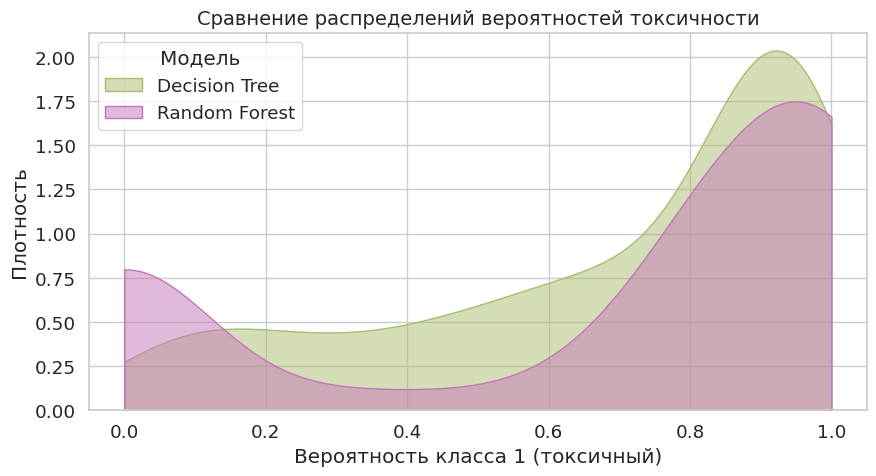

In [ ]:
# это чтобы не казалось, что модели чисто раздают 0 или 1, промежуточные варианты тоже есть
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(9, 5))

sns.kdeplot(y_proba_count[:, 1], label="Decision Tree", color="#A8BD6F", fill=True, alpha=0.5, clip=(0, 1))
sns.kdeplot(y_proba_tfidf[:, 1], label="Random Forest", color="#C576B8", fill=True, alpha=0.5, clip=(0, 1))

plt.title("Сравнение распределений вероятностей токсичности", fontsize=14)
plt.xlabel("Вероятность класса 1 (токсичный)")
plt.ylabel("Плотность")
plt.legend(title="Модель", loc="upper left")
plt.tight_layout()
plt.show()

### Выводы

Среди первых 10 почти все и вправду токсичные. Исключение – *I'm going to hug an immigrant tomorrow.* Так как большинство высказываний в сторону иммигрантов негативный, неудивительно, что классификатор обучился всем высказываниям с этим словом присваивать токсичность. Ни один не совпал, но у обоих классификаторов хороший ф-скор. Из интересных наблюдений, сами тексты с обзывательствами и слерами как раз устроены так, что модель на векторизации по словам показала бы плохие результаты. Возможно, лучше было бы даже взять не char_wb, а обычный char, но подстраивать под данные как-то не очень хорошо. Для слова *imm1grants* особенно актуально использовать n-граммный векторизатор, так как подобные неполноценные слова не будут как раз учитываться при классификации.

## Задание 3 (2 балла - 0,5 балл за каждый классификатор)

Для классификаторов Logistic Regression, Decision Trees, Naive Bayes, RandomForest найдите способ извлечь важность признаков для предсказания токсичного класса (любой из датасетов). Сопоставьте полученные числа со словами (или нграммами) в словаре и найдите топ - 5 "токсичных" слов для каждого из классификаторов.

Важное требование: в топе не должно быть стоп-слов. Для этого вам нужно будет правильным образом настроить векторизацию.
Также как и в предыдущем задании у классификаторов должно быть задано вручную как минимум 2 параметра (по возможности, f1 мера каждого из классификаторов должна быть минимум 0.6)

In [16]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [18]:
len(Counter([x['functionality'] for x in split_dataset['train']]))

29

In [21]:
split_dataset['train'][0]

{'functionality': 'spell_space_add_h',
 'text': 'I am going to shoot the next M u s l i m I see. ',
 'is_hateful': 'hateful',
 'lang': 'eng'}

In [694]:
from sklearn.pipeline import FeatureUnion

vectorizer = FeatureUnion([
    ('word', TfidfVectorizer(analyzer='word', max_features=2000, stop_words='english', ngram_range=(1,3), max_df=0.3)),
    ('char', TfidfVectorizer(analyzer='char', max_features=800, ngram_range=(6,10), min_df=0.05, max_df=0.2))
])

In [695]:
X_train = vectorizer.fit_transform(train)
X_test = vectorizer.transform(test)
feature_names = np.array(vectorizer.get_feature_names_out())

In [696]:
feature_names

array(['word__2020', 'word__4ssholes', 'word__abhor', ..., 'char__you ar',
       'char__you are', 'char__you are '], dtype=object)

In [697]:
weights = {x: round(y / sum(Counter(train_labels).values()), 3) for x, y in Counter(train_labels).items()}

In [734]:
models = {
    "LogReg": LogisticRegression(max_iter=300,
                                #  class_weight=weights,
                                 solver='liblinear',
                                 penalty='l1',
                                #  intercept_scaling=0.8,
                                #  fit_intercept=True,
                                #  verbose=3
                                 ),
    "DecisionTree": DecisionTreeClassifier(max_depth=150,
                                          splitter='best',
                                          min_samples_leaf=2,
                                          class_weight='balanced',
                                          criterion='log_loss',
                                           random_state=25,
                                          #  max_features='sqrt',
                                          ),
    "NaiveBayes": MultinomialNB(alpha=0.5, fit_prior=True),
    # "RandomForest": RandomForestClassifier(n_estimators=500,
    #                                       max_depth=100)
    "RandomForest": RandomForestClassifier(n_estimators=300,
                                          max_depth=100,
                                          # min_samples_split=5,
                                          # min_samples_leaf=3,
                                          # max_features='sqrt',
                                          class_weight='balanced',
                                          random_state=25
)
}

In [735]:
results = {}

for name, model in models.items():
    model.fit(X_train, train_labels)
    preds = model.predict(X_test)
    f1 = f1_score(test_labels, preds)
    print(f"{'◦'*20} {name} — F1: {f1:.3f} {'◦'*20}")
    print(classification_report(test_labels, preds), end='\n')
    results[name] = f1

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ LogReg — F1: 0.957 ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       127
           1       0.92      0.99      0.96       246

    accuracy                           0.94       373
   macro avg       0.95      0.92      0.93       373
weighted avg       0.94      0.94      0.94       373

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ DecisionTree — F1: 0.851 ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       127
           1       0.88      0.82      0.85       246

    accuracy                           0.81       373
   macro avg       0.79      0.80      0.79       373
weighted avg       0.82      0.81      0.81       373

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ NaiveBayes — F1: 0.920 ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       127
           1       0.87      0.98      0.92 

In [736]:
def get_top_features(model, feature_names, top_n=5):
    if hasattr(model, "coef_"):
        importances = model.coef_[0]
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif isinstance(model, MultinomialNB):
        importances = model.feature_log_prob_[1]
    top_indices = np.argsort(importances)[-top_n:][::-1]
    top_words = feature_names[top_indices]
    top_scores = importances[top_indices]
    return list(zip(top_words, top_scores))

In [737]:
for name, model in models.items():
    top_n = 10
    top_features = get_top_features(model, feature_names, top_n=top_n)
    print(f"{name} — топ-{top_n} токсичных слов:")
    for word, score in top_features:
        print(f"  {word:<20} {score:.4f}")
    print()

LogReg — топ-10 токсичных слов:
  char__immigr         7.8123
  word__just           6.2739
  word__country        6.1117
  word__woman          5.7220
  word__gay            5.6999
  word__women          5.6346
  word__typical        5.5471
  char__disabl         5.0203
  char__ nothin        3.9448
  word__black          3.7622

DecisionTree — топ-10 токсичных слов:
  char__ nothing       0.0386
  word__women          0.0369
  word__just           0.0325
  word__gay            0.0301
  word__country        0.0299
  char__ like          0.0262
  word__muslims        0.0259
  word__trans          0.0245
  word__immigrants     0.0216
  word__typical        0.0210

NaiveBayes — топ-10 токсичных слов:
  char__ women         -5.1163
  char__women          -5.1590
  char__muslim         -5.1791
  char__ in th         -5.1959
  char__ just          -5.2170
  char__ muslim        -5.4055
  char__ musli         -5.4055
  word__country        -5.4189
  char__ that          -5.4772
  char__musli

все четыре модели сходятся на социальной тематике — этнические, гендерные маркеры:
women, gay, muslim, immigrants, country, typical, trans и т.п.

это типичные токены для токсичной лексики в англоязычных текстах – эти слова часто встречаются в оскорбительных контекстах, хотя сами по себе не являются окрашенными. по сути именно эти социальные прослойки подвержены хейт спичу. типичных slur-ов (типа f*ggot, который встречался в выборке) в топе не встречается, так как они более табуированы и меньше встречались.  

комментарий по пайплайну: дело в том, что char-векторизации дает качество лучше, а word (особенно со stop-words) – более осмысленное и анализируемое. поэтому я использовала объединенный пайплайн. из минусов – при char векторизации (кроме как подбором частоты) невозможно избавиться от условных стоп-слов (посимвольный the, например, все ранво будет отлавливаться), поэтому среди важностей признаков иногда могут встречаться неосмысленные какие-то сочетания, тем более абсолютно не логично "токсичные". char_wb показывал худшие метрики, поэтому я выбрала просто char.

# Задание 4* (2 балла)

Составьте ансамблевый классификатор вручную. Используя один из парных датасетов в `glue` (например, `mnli`) обучите как минимум 10 разных классификаторов (так как количество алгоритмов меньше 10, используйте разные комбинации параметров в векторайзерах и в классификаторах, например, tfidf + logreg и countvectorizer+logreg). Чем сильнее каждый классификатор отличается от другого, тем лучше.

Вместо стандартного разбиения на train и test, разбейте выборку на 3 части: train, dev и test. Используйте train для обучения 10 классификаторов. Сделайте предсказания всеми классификаторами для dev и test датасетов. Используя объединенные предсказания всех классификаторов на dev части как признаки, обучите еще один общий классификатор. Сделайте предсказания общим классификатором на test части (опять же используйте предсказания 10 классификаторов как признаки) и рассчитайте качество итоговой классификации.

Также отдельно оцените качество на test части для каждого из 10 классификаторов. Сравните с общей оценкой. Превосходит ли общий классификатор в качестве самый лучший из отдельных классификаторов?

In [43]:
from tqdm import tqdm
from scipy.sparse import hstack
from datasets import load_dataset
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
data = load_dataset("glue", "qqp")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


The Quora Question Pairs2 dataset is a collection of question pairs from the community question-answering website Quora. The task is to determine whether a pair of questions are semantically equivalent.

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

In [55]:
train = data["train"].shuffle(seed=42).select(range(20000))
dev = data["validation"].select(range(10000))
test = data["validation"].select(range(10000, 15000))

In [59]:
def map_train_qs(data, name):
    return [x[name] for x in data]

q1_train = map_train_qs(train, 'question1')
q2_train = map_train_qs(train, 'question2')
y_train = [x['label'] for x in train]

q1_dev = map_train_qs(dev, 'question1')
q2_dev = map_train_qs(dev, 'question2')
y_dev = [x['label'] for x in dev]

q1_test = map_train_qs(test, 'question1')
q2_test = map_train_qs(test, 'question2')
y_test = [x['label'] for x in test]

In [19]:
models = {
    "LogReg_TFIDF": (
        TfidfVectorizer(max_features=7000, ngram_range=(1, 2), sublinear_tf=True, min_df=3, max_df=0.9),
        TfidfVectorizer(max_features=7000, ngram_range=(1, 2), sublinear_tf=True, min_df=3, max_df=0.9),
        LogisticRegression(max_iter=1500, C=2.5, penalty='l2', solver='lbfgs', random_state=42)
    ),

    "LogReg_Count": (
        CountVectorizer(max_features=4000, ngram_range=(1, 3), min_df=5, max_df=0.85, binary=True),
        CountVectorizer(max_features=4000, ngram_range=(1, 3), min_df=5, max_df=0.85, binary=True),
        LogisticRegression(max_iter=1000, C=1.0, penalty='l1', solver='liblinear', random_state=42)
    ),

    "DecisionTree_TFIDF": (
        TfidfVectorizer(max_features=8000, ngram_range=(2, 3), min_df=2, max_df=0.95),
        TfidfVectorizer(max_features=8000, ngram_range=(2, 3), min_df=2, max_df=0.95),
        DecisionTreeClassifier(max_depth=300, min_samples_split=5, criterion='entropy', random_state=42)
    ),

    "DecisionTree_Count": (
        CountVectorizer(max_features=6000, ngram_range=(1, 1), min_df=10, max_df=0.8),
        CountVectorizer(max_features=6000, ngram_range=(1, 1), min_df=10, max_df=0.8),
        DecisionTreeClassifier(max_depth=120, min_samples_leaf=3, criterion='gini', random_state=42)
    ),

    "RandomForest_TFIDF": (
        TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.9),
        TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.9),
        RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_split=4, n_jobs=-1, random_state=42)
    ),

    "RandomForest_Count": (
        CountVectorizer(max_features=9000, ngram_range=(1, 2), min_df=3, max_df=0.95),
        CountVectorizer(max_features=9000, ngram_range=(1, 2), min_df=3, max_df=0.95),
        RandomForestClassifier(n_estimators=300, max_depth=150, min_samples_leaf=2, n_jobs=-1, random_state=42)
    ),

    "ExtraTrees_TFIDF": (
        TfidfVectorizer(max_features=6000, ngram_range=(1, 3), sublinear_tf=True, max_df=0.9),
        TfidfVectorizer(max_features=6000, ngram_range=(1, 3), sublinear_tf=True, max_df=0.9),
        ExtraTreesClassifier(n_estimators=400, max_depth=120, min_samples_split=4, n_jobs=-1, random_state=42)
    ),

    "NaiveBayes_TFIDF": (
        CountVectorizer(max_features=3500, analyzer="char_wb", ngram_range=(3, 6), min_df=0.2, max_df=0.8),
        CountVectorizer(max_features=3500, analyzer="char_wb", ngram_range=(3, 6), min_df=0.2, max_df=0.8),
        MultinomialNB(alpha=0.2)
    ),

    "NaiveBayes_Count": (
        CountVectorizer(max_features=7000, ngram_range=(1, 2), min_df=3, max_df=0.9),
        CountVectorizer(max_features=7000, ngram_range=(1, 2), min_df=3, max_df=0.9),
        MultinomialNB(alpha=0.5)
    ),

    "KNN_TFIDF": (
        TfidfVectorizer(max_features=4000, ngram_range=(1, 3), min_df=4, max_df=0.9),
        TfidfVectorizer(max_features=4000, ngram_range=(1, 3), min_df=4, max_df=0.9),
        KNeighborsClassifier(n_neighbors=7, weights='distance', metric='cosine')
    )
}

In [70]:
train_preds = {}
dev_preds = {}
test_preds = {}

for name, (vec1, vec2, clf) in tqdm(models.items()):
    # Обучение
    X1_train = vec1.fit_transform(q1_train)
    X2_train = vec2.fit_transform(q2_train)
    X_train = hstack([X1_train, X2_train])
    clf.fit(X_train, y_train)

    # Предсказания
    X1_dev = vec1.transform(q1_dev)
    X2_dev = vec2.transform(q2_dev)
    X_dev = hstack([X1_dev, X2_dev])
    dev_preds[name] = clf.predict_proba(X_dev)[:, 1]

    X1_test = vec1.transform(q1_test)
    X2_test = vec2.transform(q2_test)
    X_test = hstack([X1_test, X2_test])
    test_preds[name] = clf.predict_proba(X_test)[:, 1]

100%|██████████| 10/10 [04:20<00:00, 26.09s/it]


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import numpy as np

In [71]:
dev_probas = np.column_stack(list(dev_preds.values()))

In [116]:
meta_clf = LogisticRegression(penalty='elasticnet', class_weight='balanced', solver='saga', l1_ratio=0.9)
meta_clf.fit(dev_probas, y_dev)

LogisticRegression(class_weight='balanced', l1_ratio=0.9, penalty='elasticnet',
                   solver='saga')

In [117]:
final_preds = meta_clf.predict(np.column_stack(list(test_preds.values())))
final_f1 = f1_score(y_test, final_preds)
print(f"F1 финального ансамбля: {final_f1:.4f}")

F1 финального ансамбля: 0.6602


In [128]:
for model, probas in list(test_preds.items()):
    preds = (probas >= 0.5).astype(int)
    f1 = f1_score(y_test, preds)
    print(f"Classifier {model}: {f1:.4f}")
    print(f'{'◦'*40}')

Classifier LogReg_TFIDF: 0.5887
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier LogReg_Count: 0.5708
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier DecisionTree_TFIDF: 0.4839
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier DecisionTree_Count: 0.5100
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier RandomForest_TFIDF: 0.4993
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier RandomForest_Count: 0.4677
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier ExtraTrees_TFIDF: 0.4657
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier NaiveBayes_TFIDF: 0.4328
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier NaiveBayes_Count: 0.5992
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦
Classifier KNN_TFIDF: 0.5934
◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦


In [131]:
print(f'{'◦'*20} Финальный ансамбль {'◦'*20} ')
print(classification_report(y_test, final_preds))
print()
for model, probas in list(test_preds.items()):
    preds = (probas >= 0.5).astype(int)
    f1 = f1_score(y_test, preds)
    print(f'{'◦'*20} {model} {'◦'*20} ')
    print(classification_report(y_test, preds), end='\n\n')

◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ Финальный ансамбль ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ 
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      3130
           1       0.63      0.69      0.66      1870

    accuracy                           0.73      5000
   macro avg       0.72      0.73      0.72      5000
weighted avg       0.74      0.73      0.74      5000


◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ LogReg_TFIDF ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ 
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      3130
           1       0.65      0.54      0.59      1870

    accuracy                           0.72      5000
   macro avg       0.70      0.68      0.69      5000
weighted avg       0.71      0.72      0.71      5000


◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ LogReg_Count ◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦◦ 
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      3130
           1       0.63      0.53      0.57      1870

    ac

### Выводы


**лучший отдельный классификатор** на тестовой выборке — **NaiveBayes_Count** с F1-мерой **0.5992**, после **KNN_TFIDF** (0.5934) и **LogReg_TFIDF** (0.5887).

**финальный стекинг-ансамбль** показал **F1 = 0.6602**, что выше, чем у любого из 10 базовых классификаторов. то есть ансамблевая модель превосходит лучший отдельный классификатор на примерно 6 процентов по F1-мере.
Ансамбль также показал более сбалансированное качество по классам (F1=0.78 для класса 0 и 0.66 для класса 1), в то время как многие отдельные модели страдали от сильного перекоса (например, RandomForest и ExtraTrees демонстрировали высокий recall для класса 0, но очень низкий для класса 1).

в итоге стекинг оказался лучше и достигает более высокого результата.